In [1]:
cd ../

/media/beast/ds-drive/github/predictive-maintenance/ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from tqdm import tqdm

%matplotlib inline

tqdm.monitor_interval = 0

In [35]:
data_dir = 'data/dataset/'
model_save_path = 'data/wtte/model/saved_model.h5'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
print(telemetry.machineID.nunique())
print(failures.machineID.nunique())

100
98


## Prepare Data

In [10]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [13]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [14]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [15]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

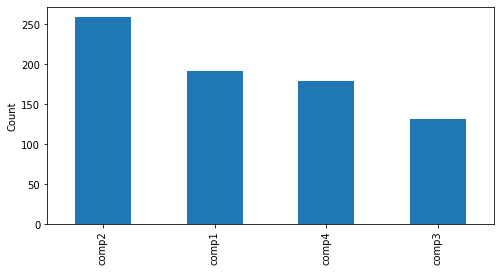

In [16]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Change the Life-cycle

In [17]:
# calculate the mean, std, max, and min values for 24h periods
def timesteps_handler(df, period='24H', fields = ['volt', 'rotate', 'pressure', 'vibration']):
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').mean().unstack())
    df_mean_xh = pd.concat(temp, axis=1)
    df_mean_xh.columns = [i + '_mean_{}'.format(period.lower()) for i in fields]
    df_mean_xh.reset_index(inplace=True)

    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').std().unstack())
    df_sd_xh = pd.concat(temp, axis=1)
    df_sd_xh.columns = [i + '_sd_{}'.format(period.lower()) for i in fields]
    df_sd_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').max().unstack())
    df_max_xh = pd.concat(temp, axis=1)
    df_max_xh.columns = [i + '_max_{}'.format(period.lower()) for i in fields]
    df_max_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').min().unstack())
    df_min_xh = pd.concat(temp, axis=1)
    df_min_xh.columns = [i + '_min_{}'.format(period.lower()) for i in fields]
    df_min_xh.reset_index(inplace=True)
    
    df = pd.concat([
        df_mean_xh,
        df_sd_xh.iloc[:, 2:6],
        df_max_xh.iloc[:, 2:6],
        df_min_xh.iloc[:, 2:6]], axis=1).dropna()
    return df

In [18]:
# 24h periods
telemetry = timesteps_handler(telemetry)
telemetry.head(10)

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,182.739113,527.349825,113.077935,51.021486,151.335682,346.149335,75.237905,25.990511
1,1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,200.872430,519.452812,127.014498,52.355876,140.776309,384.645962,78.880780,29.527665
2,1,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,194.942847,568.972310,116.008404,66.764515,154.199258,374.127148,85.246610,32.323616
3,1,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,215.656488,517.348533,118.853452,62.464103,129.016707,365.213804,82.400818,41.674887
4,1,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,202.520488,575.505189,126.464580,59.577251,127.163620,376.719605,78.721961,33.156011
5,1,2015-01-07,171.025033,454.614348,102.377665,41.506930,17.623759,43.648283,8.540959,4.298246,213.787102,508.201316,119.053113,47.829118,121.502718,345.418513,87.234149,32.813967
6,1,2015-01-08,174.139410,444.337772,96.674842,41.702771,10.611608,39.450931,10.669844,5.808709,192.154544,544.857820,120.197829,54.919547,151.641444,361.562141,80.119918,29.133905
7,1,2015-01-09,172.135931,446.126781,102.097039,39.281983,13.829868,38.445908,9.558219,4.133639,200.741045,528.596952,114.917032,45.534422,143.551174,366.201076,81.565288,29.031392
8,1,2015-01-10,169.350052,466.884090,100.128260,38.571482,14.600352,40.676186,8.463613,4.632150,197.147081,552.372925,117.164152,47.929077,143.506562,401.600459,82.653253,31.466311
9,1,2015-01-11,171.006246,455.695551,99.680231,39.789390,12.461183,33.019600,9.178725,5.427788,193.249751,521.609110,119.749926,49.667028,146.279048,400.770039,80.542301,30.127114


## Train, Validation, Test Split

In [19]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [
        pd.to_datetime("2015-08-01 01:00:00"),
        pd.to_datetime("2015-11-01 01:00:00")
]

telemetry_train = telemetry[telemetry['datetime'] < threshold_dates[0]]
telemetry_valid = telemetry[
    (telemetry['datetime'] >= threshold_dates[0]) &
    (telemetry['datetime'] < threshold_dates[1])
]
telemetry_test = telemetry[(telemetry['datetime'] >= threshold_dates[1])]

failures_train = failures[failures['datetime'] < threshold_dates[0]]
failures_valid = failures[
    (failures['datetime'] >= threshold_dates[0]) &
    (failures['datetime'] < threshold_dates[1])
]
failures_test = failures[(failures['datetime'] >= threshold_dates[1])]

print(len(telemetry_train))
print(len(telemetry_valid))
print(len(telemetry_test))
print(len(failures_train))
print(len(failures_valid))
print(len(failures_test))

21200
9200
6200
458
182
121


In [20]:
telemetry_train.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,182.739113,527.349825,113.077935,51.021486,151.335682,346.149335,75.237905,25.990511
1,1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,200.872430,519.452812,127.014498,52.355876,140.776309,384.645962,78.880780,29.527665
2,1,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,194.942847,568.972310,116.008404,66.764515,154.199258,374.127148,85.246610,32.323616
3,1,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,215.656488,517.348533,118.853452,62.464103,129.016707,365.213804,82.400818,41.674887
4,1,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,202.520488,575.505189,126.464580,59.577251,127.163620,376.719605,78.721961,33.156011


In [21]:
failures_train.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1


## Prepare the Dataset

In [22]:
def data_handler(df_telemetry, df_failure):
    sample_id = 0
    #cols = ['instance', 'timesteps', 'volt', 'rotate', 'pressure', 'vibration']
    cols = [
        "instance",
        "timesteps",
        "volt_mean_24h",
        "rotate_mean_24h",
        "pressure_mean_24h",
        "vibration_mean_24h",
        "volt_sd_24h",
        "rotate_sd_24h",
        "pressure_sd_24h",
        "vibration_sd_24h",
        "volt_max_24h",
        "rotate_max_24h",
        "pressure_max_24h",
        "vibration_max_24h",
        "volt_min_24h",
        "rotate_min_24h",
        "pressure_min_24h",
        "vibration_min_24h"
    ]
    dataset = pd.DataFrame(columns=cols)
    for machine_id in df_failure.machineID.unique():
        telemetry_sample = df_telemetry[df_telemetry['machineID'] == machine_id].sort_values(by='datetime')
        sample_failure = df_failure[df_failure['machineID'] == machine_id].sort_values(by='datetime')
        
        prev_fail_datetime = pd.to_datetime("1900-01-01 00:00:00")
        for fail_datetime in sample_failure.datetime:
            temp = telemetry_sample[
                (telemetry_sample.datetime > prev_fail_datetime) &
                (telemetry_sample.datetime < fail_datetime)
            ]
            matrix = np.concatenate(
                    (
                        np.array([sample_id] * len(temp))[:, None].astype(np.int16),
                        np.arange(len(temp))[:, None].astype(np.int16),
                        temp[cols[2:]].values
                    ), axis=1
                )
            dataset = dataset.append(pd.DataFrame(matrix, columns=cols), ignore_index=True)  
            prev_fail_datetime = fail_datetime
            sample_id += 1
    dataset['instance'] = dataset['instance'].astype(np.int16)
    dataset['timesteps'] = dataset['timesteps'].astype(np.int16)
    return dataset

In [23]:
train = data_handler(telemetry_train, failures_train)
train.head()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,0,0,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,182.739113,527.349825,113.077935,51.021486,151.335682,346.149335,75.237905,25.990511
1,0,1,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,200.872430,519.452812,127.014498,52.355876,140.776309,384.645962,78.880780,29.527665
2,0,2,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,194.942847,568.972310,116.008404,66.764515,154.199258,374.127148,85.246610,32.323616
3,0,3,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,215.656488,517.348533,118.853452,62.464103,129.016707,365.213804,82.400818,41.674887
4,1,0,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,202.520488,575.505189,126.464580,59.577251,127.163620,376.719605,78.721961,33.156011


In [24]:
train.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000
mean,220.032473,29.512354,170.849409,446.336456,100.866071,40.417442,14.908677,49.992703,10.058952,5.002932,200.224727,544.634604,120.663500,50.246147,141.555404,347.904043,81.143028,30.596283
std,127.364437,27.259666,4.806356,18.479503,4.770419,2.113309,2.289940,7.711802,1.732579,0.815785,8.868393,28.938442,7.281473,3.379810,8.380511,31.101243,6.304590,2.994624
min,0.000000,0.000000,157.888700,271.246607,90.973896,36.214705,7.612362,25.169282,4.513850,2.469382,177.280912,354.689433,101.486195,41.817077,98.337989,167.099105,51.254043,16.618570
25%,118.000000,9.000000,168.058055,441.262451,98.661209,39.378221,13.313680,44.755669,8.922475,4.451136,194.022374,527.232422,116.051950,48.027504,136.427283,332.214194,77.550628,28.870350
50%,220.000000,22.000000,170.233785,449.100803,100.115619,40.090897,14.853816,49.565005,9.927578,4.959183,199.117208,544.006769,119.358397,49.685129,141.941414,352.350348,81.220059,30.635027
75%,325.000000,42.000000,172.527129,456.348197,101.576253,40.848713,16.434678,54.877404,10.988260,5.489277,205.018882,561.891426,123.350910,51.743873,146.954718,369.229758,84.427051,32.261135
max,457.000000,190.000000,215.616491,493.381312,152.314600,61.081222,26.057620,85.888878,20.954316,10.060271,247.060615,681.038501,185.951998,76.791072,191.645382,437.380576,135.404951,51.828545


In [25]:
valid = data_handler(telemetry_valid, failures_valid)
test = data_handler(telemetry_test, failures_test)

In [26]:
valid.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000
mean,90.200451,21.806688,170.859518,445.933856,101.014145,40.477601,14.900560,50.080023,10.060186,5.020748,200.177663,544.447330,120.749804,50.304772,141.444732,347.750735,81.252851,30.547584
std,52.700609,17.940442,4.839971,19.865285,5.028827,2.251030,2.226270,7.580434,1.774432,0.811839,8.706925,29.344961,7.577732,3.444704,8.310104,31.608075,6.352614,3.091476
min,0.000000,0.000000,158.580010,284.876978,92.465926,36.570291,7.840214,26.961442,5.012431,2.672410,177.256266,394.603076,104.877752,42.203517,97.333604,138.432075,51.237106,20.104508
25%,47.000000,8.000000,168.126307,441.384374,98.727368,39.371167,13.383850,44.816772,8.910563,4.480740,194.215572,527.103056,115.993637,48.085080,136.414019,332.276381,77.692090,28.742626
50%,90.000000,17.000000,170.203717,449.306546,100.138722,40.091970,14.804599,49.831973,9.905779,4.973881,199.105083,544.328918,119.367232,49.697124,141.794366,352.801186,81.165720,30.543755
75%,135.000000,31.000000,172.572706,456.376242,101.671216,40.843746,16.343191,54.942563,10.986847,5.493609,204.808185,562.005285,123.340068,51.701265,146.529752,369.278174,84.466381,32.184740
max,181.000000,89.000000,209.718306,489.442050,150.821510,61.113082,24.723506,101.437628,28.399538,10.518458,248.481196,655.783858,180.076470,71.752014,190.924513,430.354634,124.781897,52.399720


In [27]:
test.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,61.110043,16.585114,170.923460,445.231813,101.168590,40.440674,14.999359,50.111563,10.110133,5.017251,200.505639,543.773755,120.892117,50.333161,141.483371,347.084168,81.250526,30.594362
std,36.698402,13.167817,5.096504,19.946123,5.231145,2.247399,2.249742,7.882643,1.798958,0.807656,8.911327,28.874917,7.768607,3.436882,8.571348,32.090019,6.466815,3.076996
min,0.000000,0.000000,157.745683,310.622973,92.202056,36.356403,8.218773,24.359314,5.219914,2.651839,178.227257,403.288778,104.196942,41.721406,105.661457,195.759798,59.544366,20.821090
25%,29.000000,6.000000,168.093351,440.793564,98.703137,39.328207,13.420714,44.755829,8.906939,4.464045,194.432859,526.730090,115.953342,48.068102,136.288760,331.044028,77.492318,28.772796
50%,64.000000,13.000000,170.246784,448.643454,100.142393,40.036880,14.917120,49.709421,9.974892,4.958375,199.458104,543.763602,119.403788,49.763289,141.792940,351.793442,81.230727,30.553615
75%,93.000000,24.000000,172.515687,456.132033,101.735115,40.832613,16.462536,55.282575,11.015620,5.489160,205.131427,562.047371,123.501724,51.849075,146.903875,369.053775,84.369086,32.230292
max,120.000000,59.000000,215.337898,482.598896,144.635764,60.877784,26.725027,80.252455,19.198931,9.568566,255.124717,665.434291,166.362842,68.721737,189.661628,422.455344,116.476456,46.253220


## Build Data

In [28]:
def build_data(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    
    num_features = x.shape[1]
    engine_list = np.unique(engine)

    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in tqdm(engine_list):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = np.empty((0, max_time, num_features), dtype=np.float32)

        for j in range(start, max_engine_time):
            engine_x = x[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, num_features))
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [29]:
max_time = 100

arr_train = train.values
arr_valid = valid.values
arr_test = test.values

train_x, train_y = build_data(arr_train[:, 0], arr_train[:, 1], arr_train[:, 2:], max_time, False)
valid_x, valid_y = build_data(arr_valid[:, 0], arr_valid[:, 1], arr_valid[:, 2:], max_time, False)

100%|██████████| 169/169 [00:01<00:00, 156.83it/s]


## Model

In [33]:
from pathlib import Path

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Activation, Masking
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras import backend as k
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize

In [34]:
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

In [ ]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_time, 16)))
model.add(LSTM(20, input_dim=24))
model.add(Dense(2))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=0.001))

In [ ]:
Path(model_save_path).parent.mkdir(parents=True, exist_ok=True)
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=24, verbose=1)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [ ]:
model.fit(train_x, train_y, epochs=250, batch_size=1000, validation_data=(valid_x, valid_y), callbacks=callbacks)